## 单张图片提取关键点

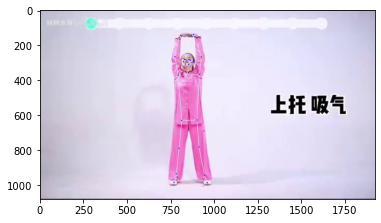

In [9]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
image = cv2.imread("./data/image/image1/0.0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image)
fig, ax = plt.subplots()
ax_image = ax.imshow(image)
ax_array = ax_image.get_array()
mp_drawing = mp.solutions.drawing_utils
mp_drawing.draw_landmarks(
    ax_array, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
ax.imshow(ax_array)
plt.show()



In [1]:

# 创建一个函数 get_landmarks，用于对指定图片进行关键点提取，并返回一个包含关键点坐标的 NumPy 数组
def get_landmarks(image):
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    results = pose.process(image)
    if results.pose_landmarks is not None: # 判断是否检测到人体姿态
        landmarks = results.pose_landmarks.landmark
        feature = []
        for i in range(len(landmarks)):
            feature[3*i:3*i+3] = landmarks[i].x,landmarks[i].y,landmarks[i].z
        return feature
    else:
        return None

现在将一个叫data文件夹下的八个文件夹里面的所有图片，都进行关键点提取，然后保存到8个csv 文件中

In [2]:
import cv2
import os
import numpy as np
import mediapipe as mp
import pandas as pd
# 创建一个 mp_pose 对象和一个 pose 对象，用于后续对图片进行关键点检测
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.6) 

# 遍历一个包含多个文件夹的主目录，并对每个文件夹下的所有图片进行关键点提取，并将结果保存到一个 CSV 文件中
root_dir ='./data/image/clean_data/image/'
for subdir in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, subdir)):
        landmarks_list = []
        for filename in os.listdir(os.path.join(root_dir, subdir)):
            if filename.endswith('.jpg'):
                image_path = os.path.join(root_dir, subdir, filename)
                image = cv2.imread(image_path) 
                landmarks = get_landmarks(image)
                if landmarks is not None: # 判断是否检测到人体姿态
                    landmarks_list.append(landmarks)
        df = pd.DataFrame(landmarks_list)
        df.to_csv(str(subdir)+'.csv', index=False)


## 对采集到的数据进行特征分析
对采集到的数据进行特征分析，可以帮助我们更好地理解和利用这些数据。以下是可能的特征分析方法：

统计关键点的分布情况：对每个关键点的出现频率进行统计，可以得到关键点在人体姿态中的分布情况。可以绘制直方图、箱线图等图表进行可视化分析。

计算关键点之间的距离：可以计算不同关键点之间的欧氏距离或曼哈顿距离，并根据距离值的大小进行分析。例如，可以计算手指的长度、肘关节到肩关节的距离等，并进行统计分析。

计算关键点之间的夹角：可以计算不同关键点之间的夹角，并根据夹角的大小进行分析。例如，可以计算手臂和手腕之间的夹角、腿部的弯曲角度等，并进行统计分析。

根据关键点的位置进行分类：可以根据不同关键点的位置将数据进行分类，并进行对比分析。例如，可以将数据按照手臂、腿部、躯干等部位进行分类，并比较不同部位的关键点分布、距离等特征。

采用机器学习方法进行分类和预测：可以使用机器学习方法对数据进行分类和预测，例如使用聚类、决策树等算法，对不同动作或姿态进行分类或预测。这样可以更深入地挖掘数据中的特征和规律，为后续的研究提供参考。

上述特征分析方法只是其中的几种，实际上还有很多其他的分析方法可以使用。最终选择哪种方法，应该根据具体的数据情况和分析目的来确定。

# 基于sklearn 的分类

In [9]:
# 数据读取
# 读入数据
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
root_path = "./data/"
datasets = pd.DataFrame()
labels = []
for i in range(1,9):
    filename = root_path+f"image{i}.csv"
    data = pd.read_csv(filename)
    datasets = pd.concat([datasets,data],axis=0)
    label = [i]*len(data)
    labels = labels + label
# 将数据合并成一个 Numpy 数组

datasets =  datasets.to_numpy()
labels = np.array(labels)
# 进行随机过采样
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(datasets, labels)
# 将数据分为训练集和测试集
# Use a utility from sklearn to split and shuffle your dataset.

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(datasets, labels, test_size=0.2, random_state=5)
print(X_train.shape)


(4993, 99)


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
import joblib


In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
# 创建一个 MLP 分类器
classifier = MLPClassifier(hidden_layer_sizes=(10,), activation='relu',
                    solver='adam', alpha=0.01, batch_size=32,
                    learning_rate='constant', learning_rate_init=0.001,
                    max_iter=200, random_state=0)
print("MLP CLASSIFIER")
print("========================================================")
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
# 计算混淆矩阵
cm = confusion_matrix(y_test, predictions)

# 计算精确率和召回率
precision = precision_score(y_test, predictions,average='macro')
recall = recall_score(y_test, predictions,average='macro')

accuracy =  metrics.accuracy_score(y_test,predictions)
print("->  Accuracy: {}% ".format(round(accuracy,4)*100))
print("P",precision,"R",recall)
joblib.dump(classifier, './model.joblib')

MLP CLASSIFIER
->  Accuracy: 99.52% 
P 0.9921080700798839 R 0.9505208333333333


['./model.joblib']

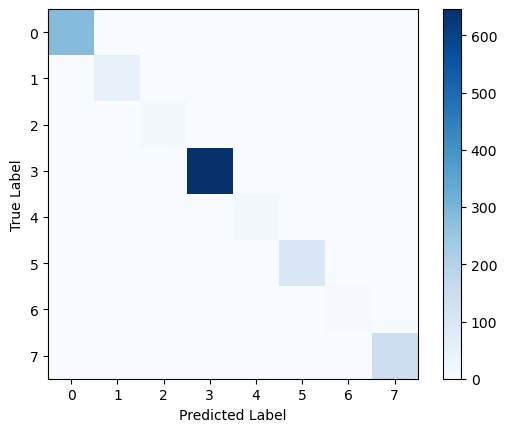

In [15]:
# 绘制混淆矩阵图
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
# tick_marks = np.arange(len(digits.target_names))
# plt.xticks(tick_marks, digits.target_names)
# plt.yticks(tick_marks, digits.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:

test_image = cv2.imread('./test.jpg')
posepoint =   get_landmarks(image) 
posepoint = np.array(posepoint)
posepoint = posepoint.reshape(1, -1)
print(posepoint.shape)
model = joblib.load('model.joblib')
prediction = model.predict(posepoint)[0]
predict_proba = np.max(model.predict_proba(posepoint)[0])
print(predict_proba)
print(prediction)

NameError: name 'cv2' is not defined

In [10]:
test_image = cv2.imread('./test.jpg')
posepoint =   get_landmarks(image) 

posepoint = posepoint.reshape(1, -1)

print(posepoint)
if test_image is not None:
    model = joblib.load('model.joblib')
    # 使用模型进行预测
    prediction = model.predict(posepoint)
    # 获取预测结果的置信度和类别
    predict_label = model.predict([posepoint])[0]
    # predict_proba = np.max(model.predict_proba([posepoint])[0])
    print(predict_label)

AttributeError: 'list' object has no attribute 'reshape'

ValueError: multiclass format is not supported